In [1]:
# Импорты библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Установка палитры для seaborn
sns.set_palette("tab10")

# Установка палитры для matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("tab10"))

In [4]:
# Загрузка данных
df = pd.read_csv('osteoporosis.csv')

In [5]:
# Исследовательский анализ данных (EDA)
print("Размеры датасета:", df.shape)
print("\nПервые 5 строк датасета:")
print(df.head())

Размеры датасета: (1958, 16)

Первые 5 строк датасета:
        Id  Age  Gender Hormonal Changes Family History    Race/Ethnicity  \
0  1734616   69  Female           Normal            Yes             Asian   
1  1419098   32  Female           Normal            Yes             Asian   
2  1797916   89  Female   Postmenopausal             No         Caucasian   
3  1805337   78  Female           Normal             No         Caucasian   
4  1351334   38    Male   Postmenopausal            Yes  African American   

   Body Weight Calcium Intake Vitamin D Intake Physical Activity Smoking  \
0  Underweight            Low       Sufficient         Sedentary     Yes   
1  Underweight            Low       Sufficient         Sedentary      No   
2       Normal       Adequate       Sufficient            Active      No   
3  Underweight       Adequate     Insufficient         Sedentary     Yes   
4       Normal            Low       Sufficient            Active     Yes   

  Alcohol Consumption    

In [6]:
print("\nИнформация о датасете:")
print(df.info())


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1958 entries, 0 to 1957
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Id                   1958 non-null   int64 
 1   Age                  1958 non-null   int64 
 2   Gender               1958 non-null   object
 3   Hormonal Changes     1958 non-null   object
 4   Family History       1958 non-null   object
 5   Race/Ethnicity       1958 non-null   object
 6   Body Weight          1958 non-null   object
 7   Calcium Intake       1958 non-null   object
 8   Vitamin D Intake     1958 non-null   object
 9   Physical Activity    1958 non-null   object
 10  Smoking              1958 non-null   object
 11  Alcohol Consumption  970 non-null    object
 12  Medical Conditions   1311 non-null   object
 13  Medications          973 non-null    object
 14  Prior Fractures      1958 non-null   object
 15  Osteoporosis         1958 non-n

In [7]:
print("\nКоличество пропущенных значений в каждом столбце:")
print(df.isnull().sum())


Количество пропущенных значений в каждом столбце:
Id                       0
Age                      0
Gender                   0
Hormonal Changes         0
Family History           0
Race/Ethnicity           0
Body Weight              0
Calcium Intake           0
Vitamin D Intake         0
Physical Activity        0
Smoking                  0
Alcohol Consumption    988
Medical Conditions     647
Medications            985
Prior Fractures          0
Osteoporosis             0
dtype: int64


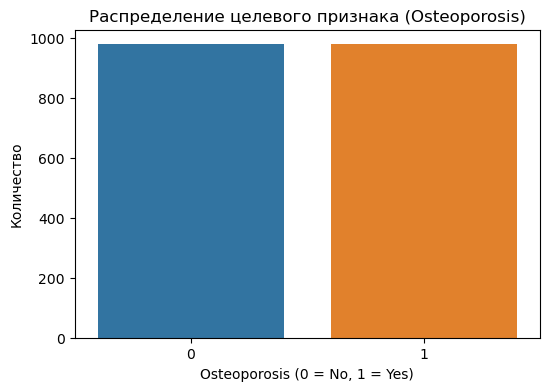

In [8]:
# Распределение целевого признака (Osteoporosis)
plt.figure(figsize=(6, 4))
sns.countplot(x='Osteoporosis', data=df)
plt.title('Распределение целевого признака (Osteoporosis)')
plt.xlabel('Osteoporosis (0 = No, 1 = Yes)')
plt.ylabel('Количество')
plt.show()

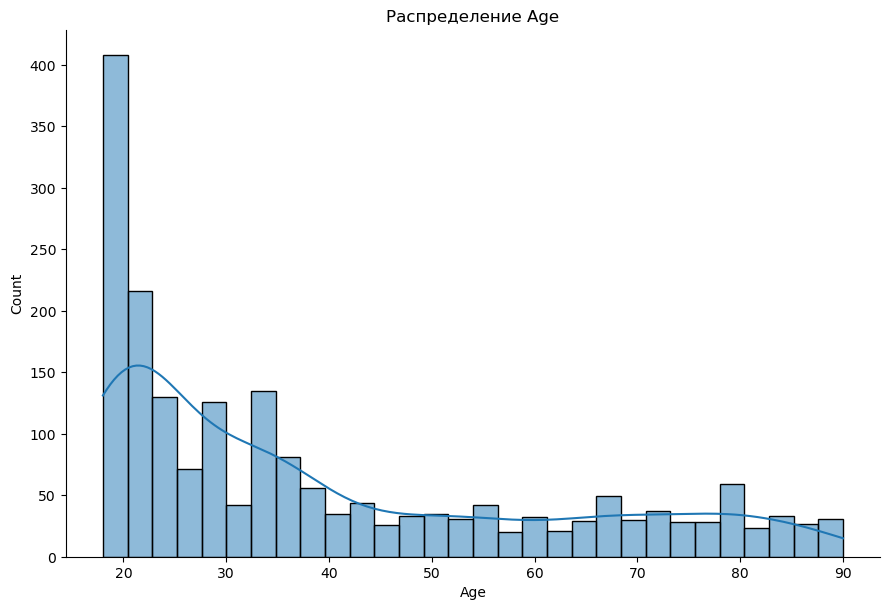

In [9]:
# Гистограммы числовых признаков с KDE
numerical_columns = ['Age']  # Добавьте другие числовые столбцы, если они есть

# Построение гистограмм с KDE для каждого признака
for column in numerical_columns:
    sns.displot(
        data=df, 
        x=column, 
        kde=True,          # Добавляем KDE
        bins=30,           # Количество бинов
        edgecolor="black", # Границы столбцов
        height=6,          # Высота графика
        aspect=1.5         # Пропорции графика
    ).set(title=f'Распределение {column}')

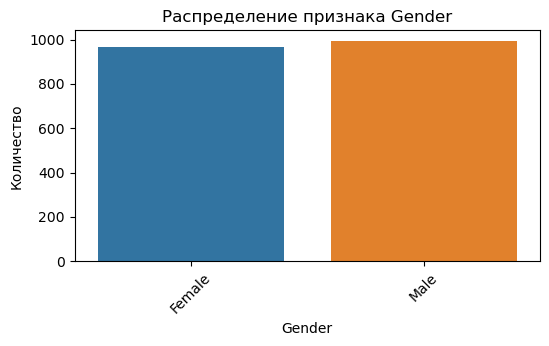

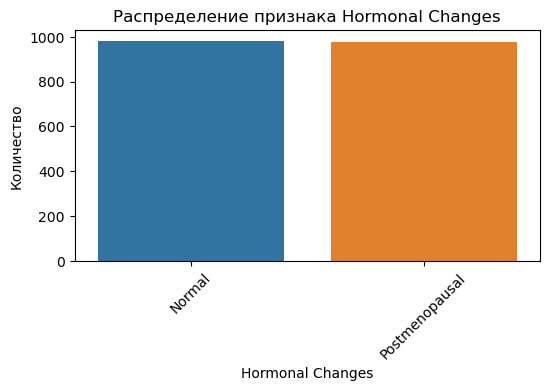

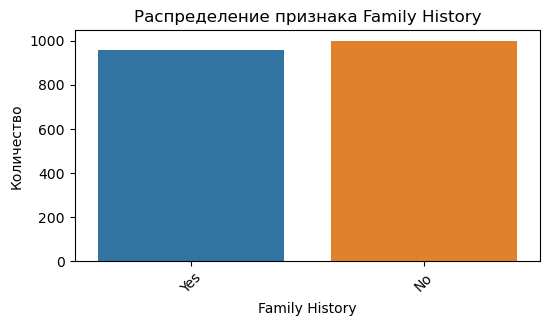

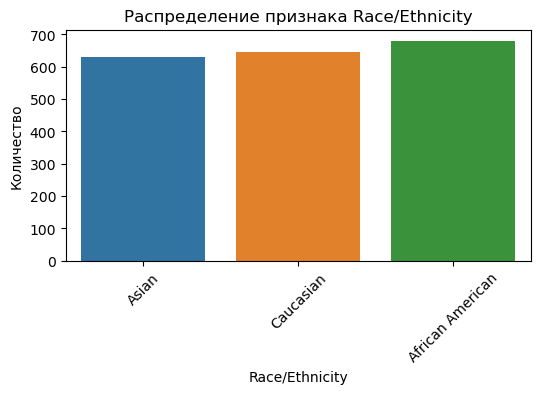

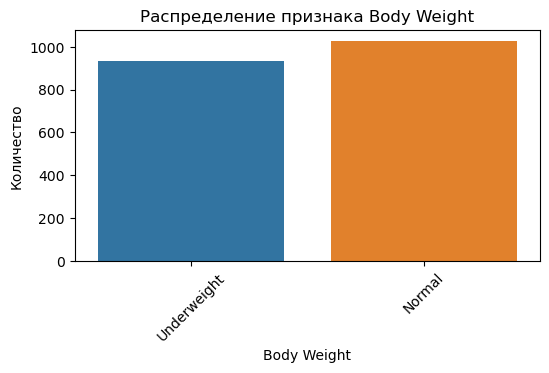

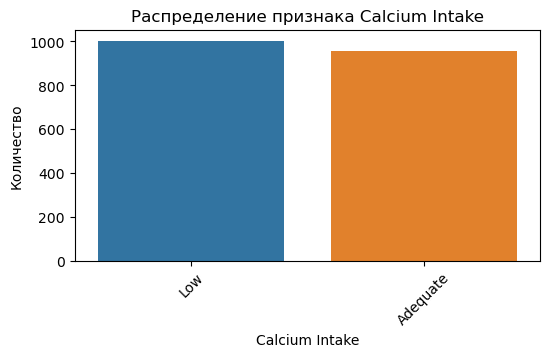

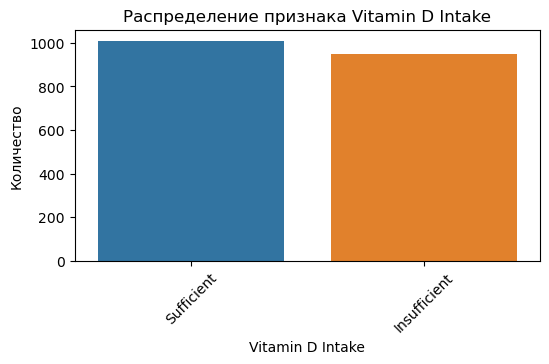

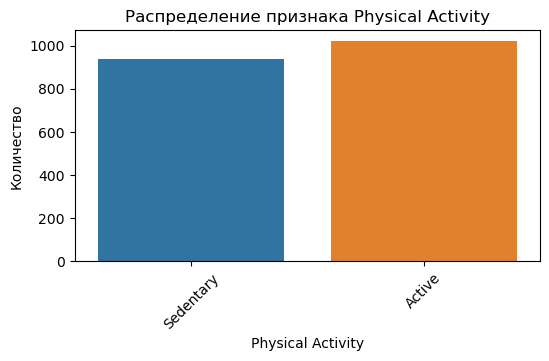

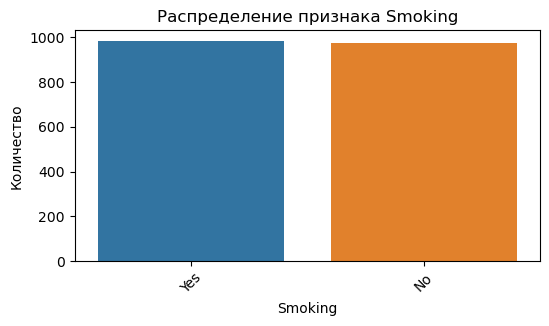

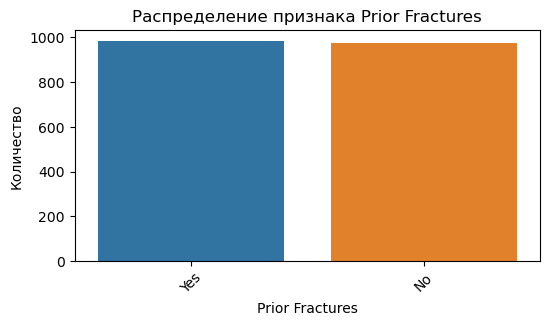

In [10]:
# Распределение категориальных признаков
categorical_columns = ['Gender', 'Hormonal Changes', 'Family History', 'Race/Ethnicity',
                       'Body Weight', 'Calcium Intake', 'Vitamin D Intake', 'Physical Activity', 
                       'Smoking', 'Prior Fractures']

for column in categorical_columns:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=column, data=df)
    plt.title(f'Распределение признака {column}')
    plt.xlabel(column)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.show()

In [11]:
# Обработка пропущенных данных
df.drop(['Medical Conditions', 'Medications'], axis=1, inplace=True)
df['Alcohol Consumption'].fillna('Unknown', inplace=True)

# Кодирование категориальных переменных
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

# Масштабирование числовых данных
scaler = StandardScaler()
df[['Age']] = scaler.fit_transform(df[['Age']])

# Разделение данных
X = df.drop(['Id', 'Osteoporosis'], axis=1)
y = df['Osteoporosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# GridSearchCV для Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf_model = grid_search_rf.best_estimator_

print("Лучшие параметры Random Forest:", grid_search_rf.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Лучшие параметры Random Forest: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


In [13]:
# GridSearchCV для CatBoost
param_grid_catboost = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 0.2]
}

catboost_model = CatBoostClassifier(random_state=42, verbose=0)
grid_search_catboost = GridSearchCV(estimator=catboost_model, param_grid=param_grid_catboost, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid_search_catboost.fit(X_train, y_train)
best_catboost_model = grid_search_catboost.best_estimator_

print("Лучшие параметры CatBoost:", grid_search_catboost.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Лучшие параметры CatBoost: {'depth': 4, 'iterations': 100, 'learning_rate': 0.1}


In [14]:
# GridSearchCV для LightGBM
param_grid_lgb = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

lgb_model = lgb.LGBMClassifier(random_state=42)
grid_search_lgb = GridSearchCV(estimator=lgb_model, param_grid=param_grid_lgb, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid_search_lgb.fit(X_train, y_train)
best_lgb_model = grid_search_lgb.best_estimator_

print("Лучшие параметры LightGBM:", grid_search_lgb.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 780, number of negative: 786
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 1566, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498084 -> initscore=-0.007663
[LightGBM] [Info] Start training from score -0.007663
Лучшие параметры LightGBM: {'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 31}


In [15]:
# GridSearchCV для XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9]
}

xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='roc_auc', cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_xgb_model = grid_search_xgb.best_estimator_

print("Лучшие параметры XGBoost:", grid_search_xgb.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Лучшие параметры XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


In [16]:
# Логистическая регрессия
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train, y_train)

# Оценка моделей
# Random Forest
y_pred_rf = best_rf_model.predict(X_test)
y_pred_rf_proba = best_rf_model.predict_proba(X_test)[:, 1]

# CatBoost
y_pred_catboost = best_catboost_model.predict(X_test)
y_pred_catboost_proba = best_catboost_model.predict_proba(X_test)[:, 1]

# LightGBM
y_pred_lgb = best_lgb_model.predict(X_test)
y_pred_lgb_proba = best_lgb_model.predict_proba(X_test)[:, 1]

# XGBoost
y_pred_xgb = best_xgb_model.predict(X_test)
y_pred_xgb_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Logistic Regression
y_pred_logreg = logreg_model.predict(X_test)
y_pred_logreg_proba = logreg_model.predict_proba(X_test)[:, 1]

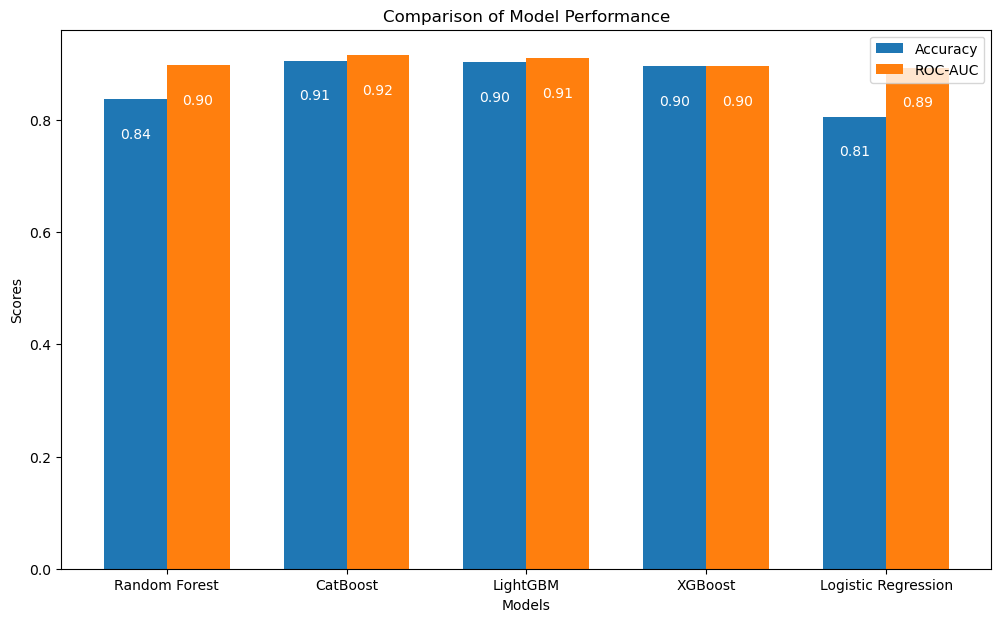

In [17]:
# Сравнение моделей
models = ['Random Forest', 'CatBoost', 'LightGBM', 'XGBoost', 'Logistic Regression']
accuracies = [
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_catboost),
    accuracy_score(y_test, y_pred_lgb),
    accuracy_score(y_test, y_pred_xgb),
    accuracy_score(y_test, y_pred_logreg)
]

roc_aucs = [
    roc_auc_score(y_test, y_pred_rf_proba),
    roc_auc_score(y_test, y_pred_catboost_proba),
    roc_auc_score(y_test, y_pred_lgb_proba),
    roc_auc_score(y_test, y_pred_xgb_proba),
    roc_auc_score(y_test, y_pred_logreg_proba)
]

# Построение графика
plt.figure(figsize=(12, 7))
x = np.arange(len(models))
width = 0.35

bars1 = plt.bar(x - width/2, accuracies, width, label='Accuracy')
bars2 = plt.bar(x + width/2, roc_aucs, width, label='ROC-AUC')

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
             f'{bar.get_height():.2f}', ha='center', va='top', color='white', fontsize=10)

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
             f'{bar.get_height():.2f}', ha='center', va='top', color='white', fontsize=10)

plt.xticks(x, models)
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.legend()
plt.show()

**Выводы по результатам работы моделей**

На основе представленного графика сравнения точности (**Accuracy**) и площади под кривой ROC (**ROC-AUC**) для разных моделей можно сделать следующие выводы:


**Общий результат:**
- Все модели продемонстрировали **высокие значения ROC-AUC** (близкие к 0.9 и выше), что свидетельствует о хорошей способности моделей различать классы (наличие или отсутствие остеопороза).
- **Точность (Accuracy)** у моделей также находится на высоком уровне, что подтверждает их качество при классификации.


**Сравнение моделей:**

**CatBoost**:
   - **Accuracy: 91%**, **ROC-AUC: 92%**
   - Это лучшая модель среди всех протестированных по обеим метрикам. CatBoost особенно хорошо работает с категориальными признаками, что, вероятно, помогло добиться наилучших результатов.
   - Рекомендуется использовать эту модель для дальнейшего анализа и развертывания.<br><br>

**LightGBM**:
   - **Accuracy: 90%**, **ROC-AUC: 91%**
   - Показал результаты, сравнимые с CatBoost, и чуть ниже по метрике ROC-AUC. LightGBM отлично справляется с большими объемами данных и может быть полезным в развертывании на практике.<br><br>

**XGBoost**:
   - **Accuracy: 90%**, **ROC-AUC: 90%**
   - Результаты чуть ниже, чем у CatBoost и LightGBM, но модель по-прежнему демонстрирует высокую производительность. XGBoost часто используется благодаря своей надежности.<br><br>

**Random Forest**:
   - **Accuracy: 84%**, **ROC-AUC: 90%**
   - Модель уступает градиентным бустингам по точности, но имеет сопоставимое значение ROC-AUC. Это объясняется тем, что Random Forest менее эффективно работает с сложными взаимосвязями между признаками.<br><br>

**Logistic Regression**:
   - **Accuracy: 81%**, **ROC-AUC: 89%**
   - Логистическая регрессия ожидаемо уступает по производительности более сложным моделям, так как плохо справляется с нелинейными зависимостями в данных.


**Рекомендации:**
- **CatBoost** — наиболее предпочтительная модель для использования, так как она обеспечивает максимальные значения Accuracy и ROC-AUC.
- **LightGBM** — отличный выбор для случаев, когда важна скорость обучения или прогнозирования.
- Для повышения качества модели возможно использование методов балансировки классов (например, SMOTE) или добавление новых признаков.
- Если вычислительные ресурсы ограничены, можно использовать **Random Forest**, так как он проще в настройке и требует меньше ресурсов.